<a href="https://colab.research.google.com/github/siabang35/CNN_Deep-Learning/blob/choice/CNN_DL01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

MEMBANGUN KLASIFIKASI GAMBAR DENGAN CNN(CONVULATIONAL NEURAL NETWORK)

In [ ]:
import os
import zipfile

local_zip = '/tmp/train.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
local_zip = '/tmp/valid.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

MELAKUKAN TRAINING PADA DATASET GAMBAR

In [ ]:
# Directory with our training dandelion pictures
train_dandelion_dir = os.path.join('/tmp/train/dandelion')

# Directory with our training grass pictures
train_grass_dir = os.path.join('/tmp/train/grass')

# Directory with our validation dandelion pictures
valid_dandelion_dir = os.path.join('/tmp/valid/dandelion')

# Directory with our validation grass pictures
valid_grass_dir = os.path.join('/tmp/valid/grass')

In [ ]:
train_dandelion_names = os.listdir(train_dandelion_dir)
print(train_dandelion_names[:8])

train_grass_names = os.listdir(train_grass_dir)
print(train_grass_names[:8])

validation_dandelion_hames = os.listdir(valid_dandelion_dir)
print(validation_dandelion_hames[:8])

validation_grass_names = os.listdir(valid_grass_dir)
print(validation_grass_names[:8])

['00000191.jpg', '00000140.jpg', '00000338.jpg', '00000218.jpg', '00000010.jpg', '00000160.jpg', '00000464.jpg', '00000291.jpg']
['00000191.jpg', '00000140.jpg', '00000338.jpg', '00000218.jpg', '00000010.jpg', '00000160.jpg', '00000464.jpg', '00000291.jpg']
['00000010.jpg', '00000020.jpg', '00000064.jpg', '00000074.jpg', '00000014.jpg', '00000061.jpg', '00000011.jpg', '00000029.jpg']
['00000010.jpg', '00000020.jpg', '00000064.jpg', '00000014.jpg', '00000061.jpg', '00000011.jpg', '00000029.jpg', '00000062.jpg']


MENAMPILKAN TOTAL HASIL TRAINING

In [ ]:
print('total training dandelion images:', len(os.listdir(train_dandelion_dir)))
print('total training grass images:', len(os.listdir(train_grass_dir)))
print('total validation dandelion images:', len(os.listdir(valid_dandelion_dir)))
print('total validation grass images:', len(os.listdir(valid_grass_dir)))

total training dandelion images: 500
total training grass images: 499
total validation dandelion images: 92
total validation grass images: 65


MEMBANGUN DATA GAMBAR BERUPA PLOT

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

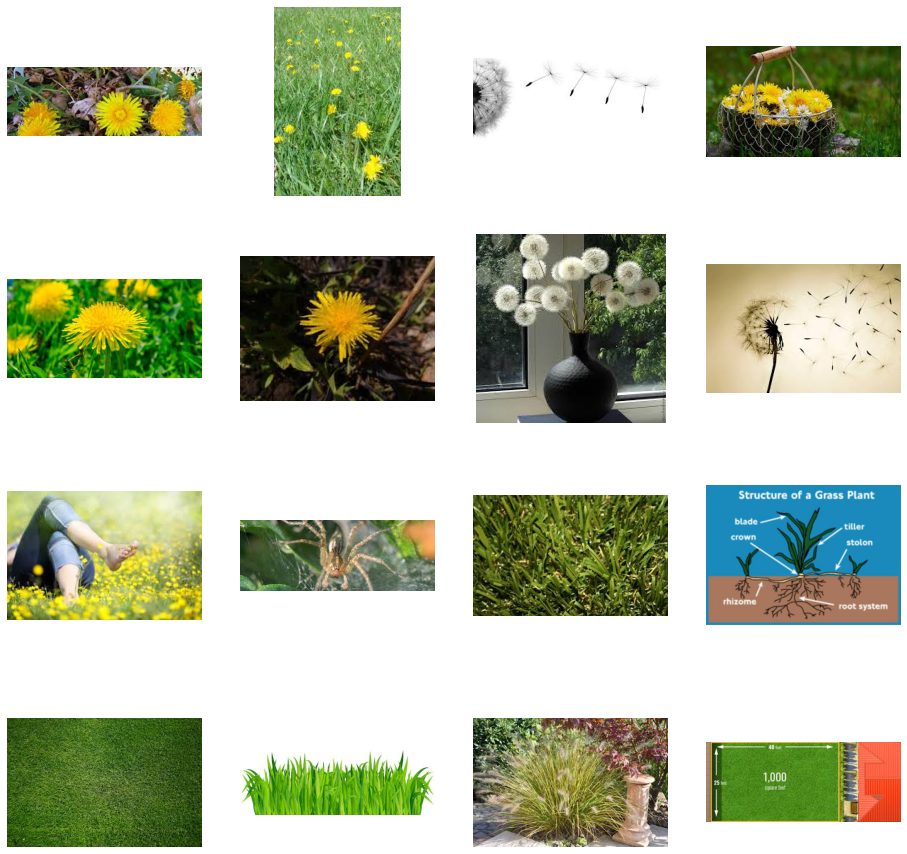

In [ ]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_dandelion_pic = [os.path.join(train_dandelion_dir, fname) 
                for fname in train_dandelion_names[pic_index-8:pic_index]]
next_grass_pic = [os.path.join(train_grass_dir, fname) 
                for fname in train_grass_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_dandelion_pic + next_grass_pic):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()


MEMULAI DATA PREPROCESSING 



In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1/255)
validation_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 120 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        '/tmp/train/',  # This is the source directory for training images
        classes = ['dandelion', 'grass'],
        target_size=(224, 224),  # All images will be resized to 200x200
        batch_size=110,
        # Use binary labels
        class_mode='binary')

# Flow validation images in batches of 19 using valid_datagen generator
validation_generator = validation_datagen.flow_from_directory(
        '/tmp/valid/',  # This is the source directory for training images
        classes = ['dandelion', 'grass'],
        target_size=(224, 224),  # All images will be resized to 200x200
        batch_size=19,
        # Use binary labels
        class_mode='binary',
        shuffle=False)

Found 999 images belonging to 2 classes.
Found 157 images belonging to 2 classes.


In [ ]:
class myCallBack(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs = ()):
    if(logs.get('accuracy') > 0.9):
      print("\nAkurasi mencapai 90%")
      self.model.stop_training = True
      
      callback = myCallBack()


MEMBANGUN MODEL DARI SCRATCH

In [ ]:
import tensorflow as tf
import numpy as np
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score


MEMBUAT LAYER MODEL

In [ ]:


model = tf.keras.models.Sequential([
# Note the input shape is the desired size of the image 200x200 with 3 bytes color
# This is the first convolution
tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(224, 224, 3)),
tf.keras.layers.MaxPooling2D(2, 2),
# The second convolution
tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
tf.keras.layers.MaxPooling2D(2,2),
# The third convolution
tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
tf.keras.layers.MaxPooling2D(2,2),
# The fourth convolution
tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
tf.keras.layers.MaxPooling2D(2,2),
# # The fifth convolution
tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
tf.keras.layers.MaxPooling2D(2,2),
# Flatten the results to feed into a DNN
tf.keras.layers.Flatten(),
# 512 neuron hidden layer
tf.keras.layers.Dense(512, activation='relu'),
# Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('dandelions') and 1 for the other ('grass')
tf.keras.layers.Dense(1, activation='sigmoid')
])



In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 111, 111, 16)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 26, 26, 64)      

In [ ]:
model.compile(optimizer = tf.optimizers.Adam(),
              loss = 'binary_crossentropy',
              metrics=['accuracy'])

PROSES LEARNING DARI TRAINING

In [ ]:
# history = model.fit(
#       train_generator,
#       steps_per_epoch=7,  
#       epochs=15,
#       verbose=1,
#       validation_data = validation_generator,
#       validation_steps=7)

history = model.fit(train_generator,
      steps_per_epoch=7,  
      epochs=15,
      verbose=1,
      validation_data = validation_generator,
      validation_steps=7)

Epoch 1/15
7/7 [==============================] - 38s 5s/step - loss: 0.4494 - accuracy: 0.7766 - val_loss: 0.6427 - val_accuracy: 0.6250
Epoch 2/15
7/7 [==============================] - 38s 6s/step - loss: 0.4490 - accuracy: 0.7831 - val_loss: 0.6161 - val_accuracy: 0.6447
Epoch 3/15
7/7 [==============================] - 40s 6s/step - loss: 0.4255 - accuracy: 0.8065 - val_loss: 0.6866 - val_accuracy: 0.5855
Epoch 4/15
7/7 [==============================] - 38s 6s/step - loss: 0.3967 - accuracy: 0.8091 - val_loss: 0.5405 - val_accuracy: 0.6974
Epoch 5/15
7/7 [==============================] - 33s 5s/step - loss: 0.3719 - accuracy: 0.8416 - val_loss: 0.5287 - val_accuracy: 0.7105
Epoch 6/15
7/7 [==============================] - 33s 5s/step - loss: 0.3919 - accuracy: 0.8356 - val_loss: 0.7376 - val_accuracy: 0.5592
Epoch 7/15
7/7 [==============================] - 35s 5s/step - loss: 0.4487 - accuracy: 0.7728 - val_loss: 0.5578 - val_accuracy: 0.6974
Epoch 8/15
7/7 [==================

In [ ]:
model.evaluate(validation_generator)

9/9 [==============================] - 2s 261ms/step - loss: 0.5363 - accuracy: 0.7070


[0.5363117456436157, 0.7070063948631287]

In [ ]:
STEP_SIZE_TEST=validation_generator.n//validation_generator.batch_size
validation_generator.reset()
preds = model.predict(validation_generator,
                      verbose=1)

9/9 [==============================] - 3s 260ms/step


ANALYSIS AKURASI DENGAN ROC CURVE DAN AUC 

In [ ]:
fpr, tpr, _ = roc_curve(validation_generator.classes, preds)

In [ ]:
roc_auc = auc(fpr, tpr)

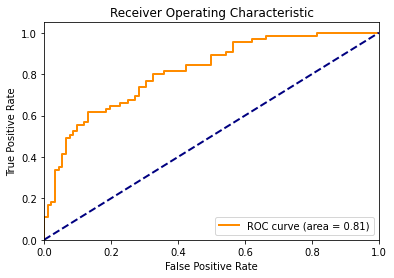

In [ ]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

MEMBUAT PREDIKSI DARI KLASIFIKASI DATASET GAMBAR

Saving rumput.jpg to rumput (1).jpg


ValueError: ignored

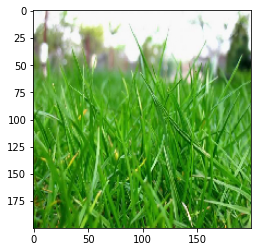

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(200, 200))
  x = image.img_to_array(img)
  plt.imshow(x/255.)
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]<0.5:
    print(fn + " is a dandelion")
  else:
    print(fn + " is a grass")
 

MODIFIKASI UNTUK VISUALISASI TRAINING DAN VALIDATION ACCURACY

In [ ]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label = 'Training Accuracy')
plt.plot(epochs,val_acc, 'b', label = 'Validation Accuracy' )
plt.title('Training and Validation accuracy')
plt.legend(loc = 'best')
plt.show()

plt.plot(epochs, loss, 'r', label = 'Training Loss')
plt.plot(epochs,val_loss, 'b', label = 'Validation Loss' )
plt.title('Training and Validation accuracy')
plt.legend(loc = 'best')
plt.show()



NameError: ignored

In [ ]:
import os, signal
os.kill(os.getpid(), signal.SIGKILL)